In [8]:
from danial import model
from danial import dataloader


import matplotlib.pyplot as plt
import torch


In [9]:
mod = model.Model()

In [10]:
test = dataloader.load_image("/home/ubd/23b6034/MHNet/assets/000001.jpg")
mod.eval()
with torch.no_grad():
    binary_pred, boundary_pred, fused_feat = mod(test)

In [11]:
print(binary_pred.shape, boundary_pred.shape, fused_feat.shape)

torch.Size([1, 5]) torch.Size([1, 4]) torch.Size([1, 64, 7, 7])


(-0.5, 6.5, 6.5, -0.5)

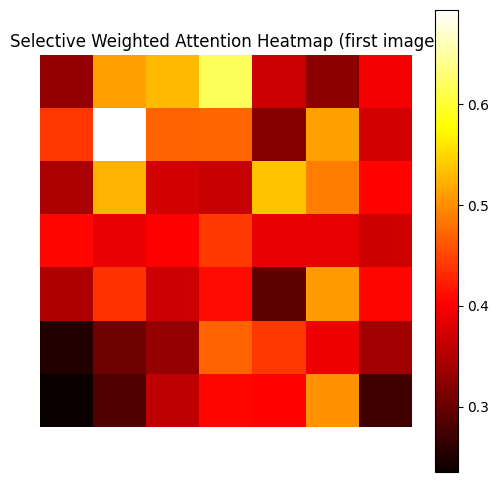

In [ ]:
plt.figure(figsize=(60,60))
plt.imshow(fused_feat[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')

In [ ]:
import kagglehub

In [ ]:

# Download latest version
path = kagglehub.dataset_download("ismailelomarialaoui/cod10k")

print("Path to dataset files:", path) # Path to dataset files: /home/ubd/.cache/kagglehub/datasets/ismailelomarialaoui/cod10k/versions/1